In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Load the processed CSV file

In [32]:
input_file = './data/processed_data.csv'

In [33]:
df = pd.read_csv(input_file)

Remove rows with NaN values

In [34]:
df.dropna(inplace=True)

In [35]:
df = df[df["Month"] == 7]

df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y%m%d%H%M")

Define the threshold for removing extreme Y values

In [36]:
threshold = 3  # Adjust this value based on your dataset and requirements

Calculate the mean and standard deviation of Y

In [37]:
mean_Y = np.mean(df['Temperature'])
std_Y = np.std(df['Temperature'])

Define the range of acceptable Y values

In [38]:
lower_bound = mean_Y - threshold * std_Y
upper_bound = mean_Y + threshold * std_Y

Filter out rows with Y values outside the acceptable range

In [39]:
df = df[(df['Temperature'] >= lower_bound) & (df['Temperature'] <= upper_bound)]

Extract the columns

In [40]:
X = df[['Month', 'Date', 'Time', 'Previous Day Average', 'Two Days Before Average', 'Three Days Before Average', 'Last 7 Days Average']].values
Y = df['Temperature'].values

Normalize X values

In [41]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Split the data into training and testing sets

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Define the model architecture

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # Output layer with 1 unit for air temperature
])

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss="mean_absolute_error")

Define early stopping and learning rate scheduler

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

Train the model

In [46]:
history = model.fit(X_train, Y_train, epochs=500, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/500
140/140 [==============================] - 3s 7ms/step - loss: 3.7669 - val_loss: 4.7392 - lr: 0.0010
Epoch 2/500
140/140 [==============================] - 1s 5ms/step - loss: 1.4143 - val_loss: 1.8012 - lr: 0.0010
Epoch 3/500
140/140 [==============================] - 1s 5ms/step - loss: 1.2990 - val_loss: 1.3584 - lr: 0.0010
Epoch 4/500
140/140 [==============================] - 1s 6ms/step - loss: 1.2696 - val_loss: 1.0034 - lr: 0.0010
Epoch 5/500
140/140 [==============================] - 1s 6ms/step - loss: 1.2671 - val_loss: 1.1221 - lr: 0.0010
Epoch 6/500
140/140 [==============================] - 1s 6ms/step - loss: 1.2462 - val_loss: 0.9743 - lr: 0.0010
Epoch 7/500
140/140 [==============================] - 1s 6ms/step - loss: 1.1914 - val_loss: 1.0788 - lr: 0.0010
Epoch 8/500
140/140 [==============================] - 1s 6ms/step - loss: 1.2177 - val_loss: 1.0186 - lr: 0.0010
Epoch 9/500
140/140 [==============================] - 1s 5ms/step - loss: 1.2023 - val_

Evaluate the model

In [47]:
loss = model.evaluate(X_test, Y_test)
print("Test loss:", loss)

70/70 [==============================] - 0s 2ms/step - loss: 0.7016
Test loss: 0.7015582919120789


Make predictions

In [48]:
predictions = model.predict(X_test)

70/70 [==============================] - 0s 2ms/step


Calculate accuracy and mean squared error (MSE)

In [49]:
from sklearn.metrics import mean_absolute_error
accuracy = 100 - np.mean(np.abs((Y_test - predictions) / Y_test)) * 100
mse = mean_squared_error(Y_test, predictions)
mas = mean_absolute_error(Y_test, predictions)

In [50]:
print("Accuracy:", accuracy)
print("Mean Squared Error (MSE):", mse)

Accuracy: 93.98671312668223
Mean Squared Error (MSE): 0.9424786244149219


Plot error (predicted - actual)

In [51]:
error = predictions.flatten() - Y_test

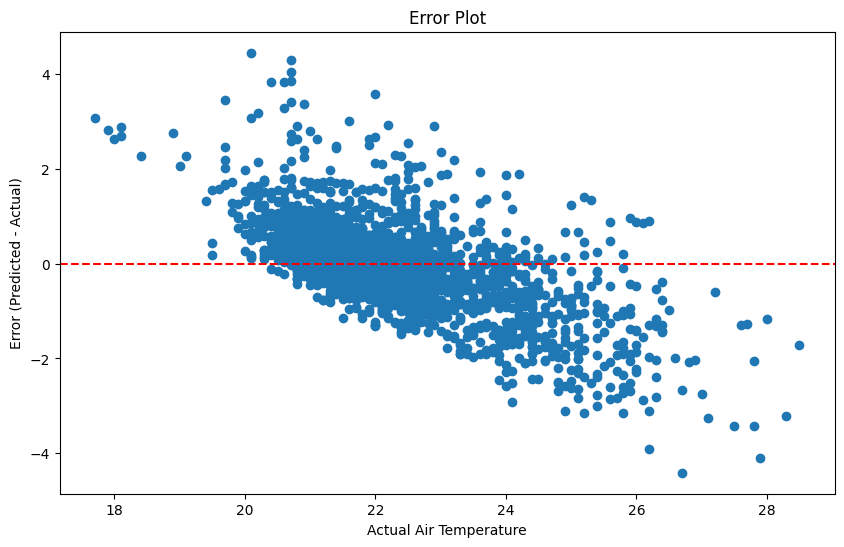

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, error)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Air Temperature')
plt.ylabel('Error (Predicted - Actual)')
plt.title('Error Plot')
plt.show()

Plot training and validation loss over epochs

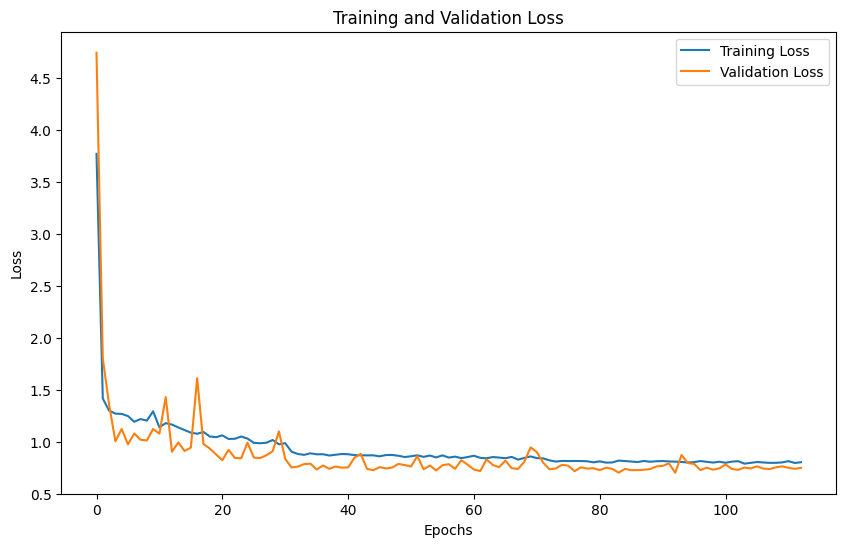

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Print some example predictions

In [54]:
for i in range(10):
    print("Predicted:", predictions[i])
    print("Actual:", Y_test[i])
    print()

Predicted: [22.340303]
Actual: 22.8

Predicted: [21.556465]
Actual: 21.5

Predicted: [21.959068]
Actual: 21.7

Predicted: [23.840136]
Actual: 23.2

Predicted: [21.048546]
Actual: 21.5

Predicted: [22.504938]
Actual: 23.5

Predicted: [21.333494]
Actual: 21.7

Predicted: [26.06747]
Actual: 25.6

Predicted: [21.049406]
Actual: 20.6

Predicted: [21.088114]
Actual: 21.4



Save the TensorFlow model

In [55]:
model.save("./model.keras")